### **Sentiment Analysis – Deep Learning (F:ull dataset)**

This notebook trains and compares **LSTM/BiLSTM** and **DistilBERT** models on the large sentiment dataset (1.6M tweets). The data is loaded directly from the remote URL.

**Data loader**

In [2]:
%matplotlib inline

import pandas as pd
import requests, zipfile, io

url = "https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/sentiment-analysis-is-bad/data/training.1600000.processed.noemoticon.csv.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
df = pd.read_csv(z.open("training.1600000.processed.noemoticon.csv"), encoding="latin-1")
df = df.sample(n=200000, random_state=42)

# Datast columns
df.columns = ["target", "ids", "date", "flag", "user", "text"]
df = df[["target", "text"]]

# Convert target from 0=negative, 4=positive
df["target"] = df["target"].replace({0:0, 4:1})

print(df.head())
print(df.shape)


        target                                               text
541200       0  @Nkluvr4eva My poor little dumpling  In Holmde...
750          0  I'm off too bed. I gotta wake up hella early t...
766711       0  I havent been able to listen to it yet  My spe...
285055       0  now remembers why solving a relatively big equ...
705995       0                           Ate too much, feel sick 
(200000, 2)


**Text cleaning (preprocessing)**

In [3]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(clean_text)
print(df["clean_text"].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


541200    poor little dumpling holmdel vids really tryin...
750          im bed gotta wake hella early tomorrow morning
766711               havent able listen yet speakers busted
285055    remembers solving relatively big equation two ...
705995                                   ate much feel sick
Name: clean_text, dtype: object


**LSTM tokenization and model build**

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Data processing
max_words = 20000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df["clean_text"])
sequences = tokenizer.texts_to_sequences(df["clean_text"])
X = pad_sequences(sequences, maxlen=max_len)
y = df["target"].values

# LSTM model
model = Sequential([
    Embedding(input_dim=max_words, output_dim=128),
    LSTM(256, dropout=0.1, recurrent_dropout=0.1),
    Dense(64, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])


model.build(input_shape=(None, max_len))

optimizer = Adam(learning_rate=1e-3)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,970,753 (11.33 MB)

 Trainable params: 2,970,753 (11.33 MB)

 Non-trainable params: 0 (0.00 B)

None


**Model training**

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=5, batch_size=512)
history_lstm = history

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.4f}")

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 69s 228ms/step - accuracy: 0.6876 - loss: 0.5709 - val_accuracy: 0.7646 - val_loss: 0.4858
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 212ms/step - accuracy: 0.7988 - loss: 0.4366 - val_accuracy: 0.7677 - val_loss: 0.4884
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 205ms/step - accuracy: 0.8187 - loss: 0.3948 - val_accuracy: 0.7628 - val_loss: 0.5038
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 216ms/step - accuracy: 0.8369 - loss: 0.3554 - val_accuracy: 0.7569 - val_loss: 0.5368
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 212ms/step - accuracy: 0.8542 - loss: 0.3188 - val_accuracy: 0.7501 - val_loss: 0.6138
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 73s 58ms/step - accuracy: 0.7542 - loss: 0.6032
Test Accuracy: 0.7568


**Confusion matrix**

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 68s 54ms/step


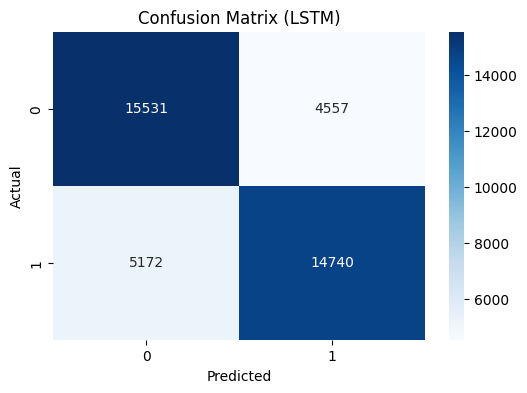

In [6]:
# Prediction (Keras LSTM)
y_pred = model.predict(X_test)

# Convert probabilities to categories
y_pred = (y_pred > 0.5).astype(int).flatten()

# Create confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (LSTM)")
plt.show()


## **DistilBERT**

In [7]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import pandas as pd
import torch

# Data processing
texts = df["clean_text"].tolist()
labels = df["target"].tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Preparing the Dataset in PyTorch format
class NewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = NewsDataset(train_encodings, train_labels)
val_dataset   = NewsDataset(val_encodings, val_labels)

# DistilBERT model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


**Model training**

In [16]:
# install evaluate if not already
!pip install evaluate -q

from transformers import Trainer, TrainingArguments
import transformers
import numpy as np
import evaluate
import traceback

print("transformers version:", transformers.__version__)

# training kwargs
training_kwargs = dict(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=200,
    report_to="none",
)

# Flexible: Tries to create TrainingArguments and does fallback between eval_strategy <-> evaluation_strategy
def make_training_args(kwargs):
    from transformers import TrainingArguments
    try:
        return TrainingArguments(**kwargs)
    except TypeError as e:
        kw = kwargs.copy()
        if 'eval_strategy' in kw and 'evaluation_strategy' not in kw:
            kw['evaluation_strategy'] = kw.pop('eval_strategy')
        elif 'evaluation_strategy' in kw and 'eval_strategy' not in kw:
            kw['eval_strategy'] = kw.pop('evaluation_strategy')
        else:
            raise
        return TrainingArguments(**kw)

try:
    training_args = make_training_args(training_kwargs)
except Exception as e:
    print("Failed to create TrainingArguments:")
    traceback.print_exc()
    raise

# Download metric from the evaluate library
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy_metric.compute(predictions=preds, references=labels)

# Create Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

# training
trainer.train()

# Evaluate and print the result
eval_results = trainer.evaluate()
if 'eval_accuracy' in eval_results:
    print(f"Test Accuracy: {eval_results['eval_accuracy']:.4f}")
else:
    print("eval_results keys:", eval_results.keys())
    print("eval_results:", eval_results)


transformers version: 4.56.1


Epoch,Training Loss,Validation Loss,Accuracy
1,0.442200,0.434085,0.796200
2,0.301000,0.508866,0.796150
3,0.199100,0.623062,0.790350
4,0.120900,0.796882,0.787550
5,0.081800,0.965164,0.785475


Test Accuracy: 0.7855


**Confusion matrix**

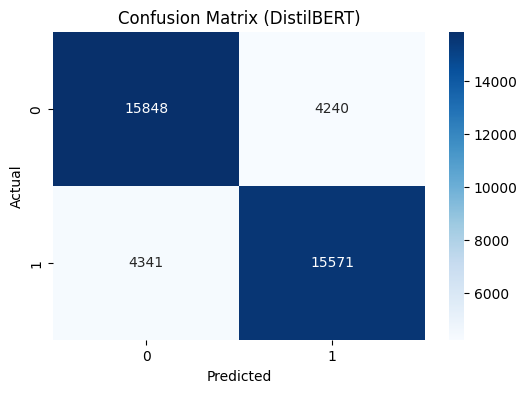

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict using val_dataset
predictions = trainer.predict(val_dataset)

# Extract forecasts
y_pred = np.argmax(predictions.predictions, axis=1)

y_true = predictions.label_ids

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# drawing the shape
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (DistilBERT)")
plt.show()

## **Performance Comparison**

LSTM Validation Accuracy: 0.7677
DistilBERT Validation Accuracy: 0.7855


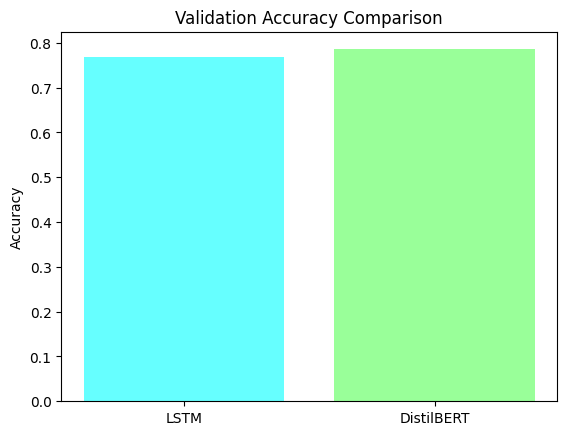

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# LSTM Validation Accuracy
lstm_acc = max(history_lstm.history['val_accuracy'])

# DistilBERT Validation Accuracy
eval_results = trainer.evaluate(val_dataset)
bert_acc = eval_results['eval_accuracy']

print(f"LSTM Validation Accuracy: {lstm_acc:.4f}")
print(f"DistilBERT Validation Accuracy: {bert_acc:.4f}")

# Comparison drawing
plt.bar(['LSTM', 'DistilBERT'], [lstm_acc, bert_acc], color=['#66FFFF', '#99FF99'])
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()